In [1]:
import matplotlib.pyplot as plt
import io
from PIL import Image, ImageChops

white = (255, 255, 255, 255)

def latex_to_img(tex):
    buf = io.BytesIO()
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.axis('off')
    plt.text(0.05, 0.5, f'${tex}$', size=40)
    plt.savefig(buf, format='png')
    plt.close()

    im = Image.open(buf)
    bg = Image.new(im.mode, im.size, white)
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    return im.crop(bbox)

In [2]:
from scipy.stats import wilcoxon
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.5f}'.format

def wilcoxon_test(results_best,results_compare):
    pvalue = wilcoxon(x=results_best,y=results_compare).pvalue
    if pvalue<=0.001:
        return {}
    elif pvalue>0.001 and pvalue<0.05:
        return {'dag':'--rwrap'}
    else:
        return {'ddag':'--rwrap'}

In [3]:
import pandas as pd
import os
from functools import partial

export_dir = '~/Dropbox/neuripshistnet'

path = "results"

def show_results_table(experiment_names,base_path='', include_std=False, row_names=None,error_measures=['AE','RAE']):
    table = pd.DataFrame(columns=error_measures,dtype='float')
    results_error = {}
    for error_measure in error_measures:
        results_error[error_measure] = dict()


    for experiment in experiment_names:
        results = pd.read_csv(os.path.join(base_path,path,experiment+'_errors.txt'))
        for error_measure in error_measures:
            results_error[error_measure][experiment] =results[error_measure]
            table.loc[experiment,error_measure] = results[error_measure].mean()

    #table = table.style.highlight_min(color = 'yellow', axis = 0)

    #get best method for ae and best method for rae
    best_method = {}
    for error_measure in error_measures:
        best_method[error_measure] = table.index[table[error_measure].argmin()]

    table_style = table.style

    #make wixcolom testing MAE
    for experiment in experiment_names:
        for error_measure in error_measures:
            if experiment!=best_method[error_measure]:
                table_style.set_properties(subset=(experiment,error_measure),**wilcoxon_test(results_error[error_measure][experiment],results_error[error_measure][best_method[error_measure]]))
        
    for error_measure in error_measures:    
        table_style = table_style.highlight_min(axis=0,props='textbf:--rwrap;',subset=error_measure)
    #table = table.style.highlight_min(color = 'yellow', axis = 0)

    def add_deviation(x,std):
        return "{:.5f}".format(x)+' $\pm$ ' +"{:.5f}".format(std)

    use_f = lambda x: partial(add_deviation, std=x)
    formatters = [add_deviation]

    if include_std:
        for experiment_name in experiment_names:
            for error_measure in error_measures:
                std_value = results_error[error_measure][experiment_name].std()
                table_style = table_style.format(formatter=use_f(std_value),subset=(experiment_name,error_measure))
            

    latex_code = table_style.to_latex(hrules=True,column_format="r|"+"r"*len(table.columns))
    if row_names is not None:
        for experiment_name,row_name in zip(experiment_names,row_names):
            latex_code = latex_code.replace(experiment_name,row_name)

    return latex_code.replace("_","\\_"), results_error

## Número de parámetros de cada red

In [ ]:
import torch
def get_num_parameters(state_dict):
    return sum(p.numel() for p in state_dict.values())

experiment_names = ["deepsets_avg_T1A","deepsets_max_T1A","deepsets_median_T1A","settransformers_T1A","histnet_sigmoid_T1A","histnet_hard_T1A","histnet_soft_T1A","histnet_softrbf_T1A","deepsets_avg_T1B","deepsets_max_T1B","deepsets_median_T1B","settransformers_T1B","histnet_sigmoid_T1B","histnet_hard_T1B","histnet_soft_T1B","histnet_softrbf_T1B"]
for experiment in experiment_names:
    #load the model
    print(experiment+":"+str(get_num_parameters(torch.load(os.path.join('savedmodels',experiment+'.pkl')))))


deepsets_avg_T1A:10678574
deepsets_max_T1A:10678574
deepsets_median_T1A:10678574
settransformers_T1A:14185774
histnet_sigmoid_T1A:29725038
histnet_hard_T1A:29840174
histnet_soft_T1A:29840174
histnet_softrbf_T1A:29820974
deepsets_avg_T1B:3048988
deepsets_max_T1B:3048988
deepsets_median_T1B:3048988
settransformers_T1B:67434524
histnet_sigmoid_T1B:68060764
histnet_hard_T1B:68257308
histnet_soft_T1B:68257308
histnet_softrbf_T1B:68224540


## Results T1A

In [5]:
experiment_names = ["deepsets_avg_T1A","deepsets_max_T1A","deepsets_median_T1A","settransformers_T1A","histnet_hard_T1A"]
row_names = ["Deepsets (avg)","Deepsets (max)","Deepsets (median)","SetTransformers","HistNetQ"]
t1a_table,_ = show_results_table(experiment_names=experiment_names, base_path='', include_std=True,error_measures=['AE','RAE'], row_names=row_names)
print(t1a_table)
with open(os.path.join(export_dir,'tables/t1a_table.tex'),'w') as f:
    f.write(t1a_table)


\begin{tabular}{r|rr}
\toprule
{} & {AE} & {RAE} \\
\midrule
Deepsets (avg) & 0.03263 $\pm$ 0.02488 & 0.14692 $\pm$ 0.28142 \\
Deepsets (max) & 0.05701 $\pm$ 0.04911 & 0.22865 $\pm$ 0.46184 \\
Deepsets (median) & 0.04569 $\pm$ 0.03578 & 0.19327 $\pm$ 0.31328 \\
SetTransformers & 0.03681 $\pm$ 0.02735 & 0.15534 $\pm$ 0.20086 \\
HistNetQ & \textbf{0.02786 $\pm$ 0.02060} & \textbf{0.12654 $\pm$ 0.24640} \\
\bottomrule
\end{tabular}



FileNotFoundError: [Errno 2] No such file or directory: '~/Dropbox/neuripshistnet/tables/t1a_table.tex'

## Results T1B

In [6]:
experiment_names = ["deepsets_avg_T1B","deepsets_median_T1B","settransformers_T1B","histnet_hard_T1B_64bins"]
row_names = ["Deepsets (avg)","Deepsets (median)","SetTransformers","HistNetQ"]
t1b_table,_=show_results_table(experiment_names,include_std=True,row_names=row_names)
print(t1b_table)
with open(os.path.join(export_dir,'tables/t1b_table.tex'),'w') as f:
    f.write(t1b_table)

\begin{tabular}{r|rr}
\toprule
{} & {AE} & {RAE} \\
\midrule
Deepsets (avg) & 0.04488 $\pm$ 0.00749 & 1.50290 $\pm$ 1.43556 \\
Deepsets (median) & \textbf{0.01855 $\pm$ 0.00600} & \textbf{1.04310 $\pm$ 0.73204} \\
SetTransformers & 0.03113 $\pm$ 0.00395 & 4.24157 $\pm$ 2.66019 \\
HistNetQ & 0.04453 $\pm$ 0.00763 & 1.51080 $\pm$ 1.45367 \\
\bottomrule
\end{tabular}



FileNotFoundError: [Errno 2] No such file or directory: '~/Dropbox/neuripshistnet/tables/t1b_table.tex'

## Análisis por número de bins

\begin{tabular}{r|rr}
\toprule
 & AE & RAE \\
\midrule
HistNet (8 bins) & 0.02966 $\pm$ 0.00820 & 1.28782 $\pm$ 0.99960 \\
HistNet (16 bins) & 0.02120 $\pm$ 0.00710 & 1.05719 $\pm$ 0.73762 \\
HistNet (32 bins) & 0.01212 $\pm$ 0.00482 & 0.78514 $\pm$ 0.51994 \\
HistNet (32 bins)\_64bins & \textbf{0.01070 $\pm$ 0.00367} & \textbf{0.75739 $\pm$ 0.48891} \\
\bottomrule
\end{tabular}



/tmp/ipykernel_5755/796027224.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chart_data = chart_data.append({"n_bins":8,"rae":results_error['RAE']['histnet_hard_T1B_8bins'].mean()},ignore_index=True)
/tmp/ipykernel_5755/796027224.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chart_data = chart_data.append({"n_bins":16,"rae":results_error['RAE']['histnet_hard_T1B_16bins'].mean()},ignore_index=True)
/tmp/ipykernel_5755/796027224.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chart_data = chart_data.append({"n_bins":32,"rae":results_error['RAE']['histnet_hard_T1B'].mean()},ignore_index=True)
/tmp/ipykernel_5755/796027224.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pan

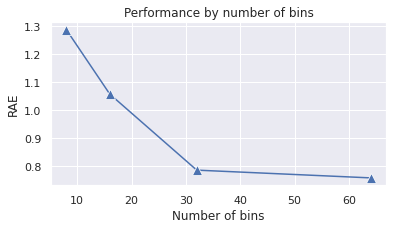

In [61]:
import numpy as np
import seaborn as sns
sns.set_theme()
experiment_names = ["histnet_hard_T1B_8bins","histnet_hard_T1B_16bins","histnet_hard_T1B","histnet_hard_T1B_64bins"]
row_names = ["HistNet (8 bins)","HistNet (16 bins)","HistNet (32 bins)","HistNet (64 bins)"]
bins_comp, results_error=show_results_table(experiment_names, row_names = row_names, include_std=True)
print(bins_comp)
with open(os.path.join(export_dir,'tables/bins_comp.tex'),'w') as f:
    f.write(bins_comp)

chart_data = pd.DataFrame(columns=("n_bins","rae"),dtype = ('int','float'))
chart_data = chart_data.append({"n_bins":8,"rae":results_error['RAE']['histnet_hard_T1B_8bins'].mean()},ignore_index=True)
chart_data = chart_data.append({"n_bins":16,"rae":results_error['RAE']['histnet_hard_T1B_16bins'].mean()},ignore_index=True)
chart_data = chart_data.append({"n_bins":32,"rae":results_error['RAE']['histnet_hard_T1B'].mean()},ignore_index=True)
chart_data = chart_data.append({"n_bins":64,"rae":results_error['RAE']['histnet_hard_T1B_64bins'].mean()},ignore_index=True)
chart_data.n_bins = chart_data.n_bins.astype(int)

plt.figure(figsize=(6,3))
sns.lineplot(data=chart_data,x='n_bins',y='rae',marker='^',markersize=10)
plt.xlabel("Number of bins")
plt.ylabel("RAE")
plt.title("Performance by number of bins")
plt.savefig(os.path.join(export_dir,'figures/bybins.pdf'), dpi=300, bbox_inches='tight')


## ISAB como feature extraction

\begin{tabular}{r|rr}
\toprule
{} & {AE} & {RAE} \\
\midrule
isab\_deepsets\_max\_T1B & 0.026447 & 1.921214 \\
isab\_deepsets\_avg\_T1B & \textbf{0.016090} & \dag{1.194885} \\
isab\_deepsets\_median\_T1B & 0.016574 & \textbf{1.181001} \\
isab\_histnet\_sigmoid\_T1B & 0.042871 & 2.145537 \\
isab\_histnet\_soft\_T1B & 0.044312 & 2.163680 \\
isab\_histnet\_softrbf\_T1B & 0.043130 & 2.158914 \\
isab\_histnet\_hard\_T1B & 0.043544 & 1.992917 \\
\bottomrule
\end{tabular}



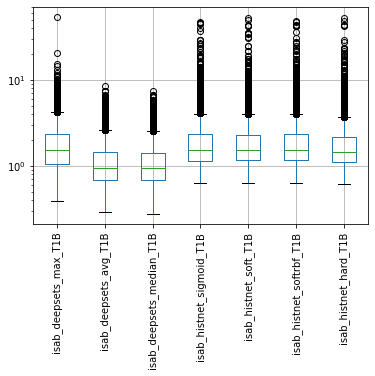

In [ ]:
experiment_names = ["isab_deepsets_max_T1B","isab_deepsets_avg_T1B","isab_deepsets_median_T1B","isab_histnet_sigmoid_T1B","isab_histnet_soft_T1B","isab_histnet_softrbf_T1B","isab_histnet_hard_T1B"]
isab_comp=show_results_table(experiment_names)
print(isab_comp)
with open(os.path.join(export_dir,'tables/isab_as_fe.tex'),'w') as f:
    f.write(isab_comp)

## No fe extraction

\begin{tabular}{r|rr}
\toprule
{} & {AE} & {RAE} \\
\midrule
norff\_settransformers\_T1B & 0.021691 & 1.296706 \\
norff\_deepsets\_max\_T1B & 0.065511 & 5.341582 \\
norff\_deepsets\_avg\_T1B & \textbf{0.019429} & \textbf{1.038535} \\
norff\_deepsets\_median\_T1B & 0.023516 & 1.137903 \\
norff\_histnet\_sigmoid\_T1B & 0.022918 & 1.675030 \\
norff\_histnet\_soft\_T1B & 0.023768 & 1.825683 \\
norff\_histnet\_softrbf\_T1B & 0.024449 & 1.602075 \\
norff\_histnet\_hard\_T1B & 0.024386 & 1.262156 \\
\bottomrule
\end{tabular}



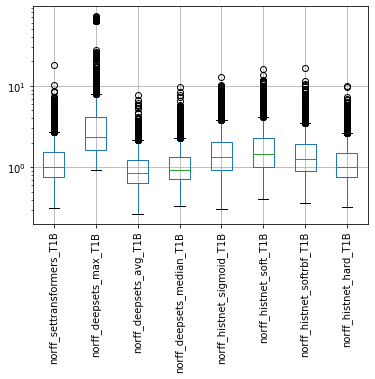

In [ ]:
experiment_names = ["norff_settransformers_T1B","norff_deepsets_max_T1B","norff_deepsets_avg_T1B","norff_deepsets_median_T1B","norff_histnet_sigmoid_T1B","norff_histnet_soft_T1B","norff_histnet_softrbf_T1B","norff_histnet_hard_T1B"]
nofe_comp=show_results_table(experiment_names)
print(nofe_comp)
with open(os.path.join(export_dir,'tables/nofe.tex'),'w') as f:
    f.write(nofe_comp)

## Resultados en el dataset MNIST
Básicamente este experimento consiste en un APP sobre el conjunto de test con 5000 muestras de prueba.

\begin{tabular}{r|rr}
\toprule
{} & {AE} & {RAE} \\
\midrule
settransformers\_mnist & 0.005365 & 0.193614 \\
deepsets\_max\_mnist & 0.018962 & 0.314427 \\
deepsets\_avg\_mnist & 0.006456 & 0.245147 \\
deepsets\_median\_mnist & 0.006318 & 0.223769 \\
histnet\_softrbf\_mnist & 0.004568 & 0.201368 \\
histnet\_hard\_mnist & 0.003957 & 0.185075 \\
CC\_mnist & 0.001767 & 0.045837 \\
AC\_mnist & 0.001623 & 0.042435 \\
PAC\_mnist & \textbf{0.001456} & 0.038079 \\
HDy\_mnist & 0.002046 & 0.040856 \\
EM\_mnist & 0.001527 & \textbf{0.027106} \\
\bottomrule
\end{tabular}



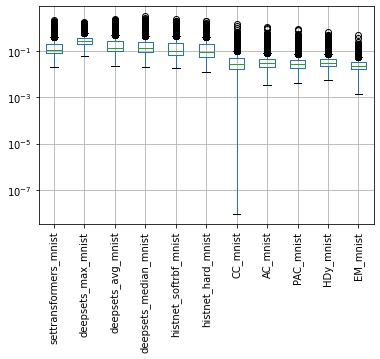

In [14]:
experiment_names = ["settransformers_mnist","deepsets_max_mnist","deepsets_avg_mnist","deepsets_median_mnist","histnet_softrbf_mnist","histnet_hard_mnist","CC_mnist","AC_mnist","PAC_mnist","HDy_mnist","EM_mnist"]
mnist_results=show_results_table(experiment_names,base_path='cifar_mnist')
print(mnist_results)
with open(os.path.join(export_dir,'tables/mnist.tex'),'w') as f:
    f.write(mnist_results)

## Resultados CIFAR 10

\begin{tabular}{r|rr}
\toprule
{} & {AE} & {RAE} & {MSE} \\
\midrule
settransformers\_ae\_pretrained\_cifar10 & 0.010027 & 0.371105 & 0.000187 \\
deepsets\_avg\_ae\_pretrained\_cifar10 & 0.012029 & 0.445794 & 0.000250 \\
histnet\_hard\_ae\_pretrained\_cifar10 & 0.010319 & 0.404029 & 0.000210 \\
CC\_cifar10 & 0.021513 & 0.812228 & 0.000916 \\
AC\_cifar10 & 0.009870 & 0.248992 & 0.000178 \\
PAC\_cifar10 & 0.008492 & 0.210952 & 0.000133 \\
HDy\_cifar10 & 0.008729 & 0.190653 & 0.000141 \\
EM\_cifar10 & 0.016648 & 0.387251 & 0.000586 \\
EM-NBVS\_cifar10 & 0.008597 & 0.173863 & 0.000139 \\
EM-BCTS\_cifar10 & 0.017240 & 0.359899 & 0.000647 \\
EM-VS\_cifar10 & \textbf{0.007613} & \textbf{0.168912} & \textbf{0.000109} \\
\bottomrule
\end{tabular}



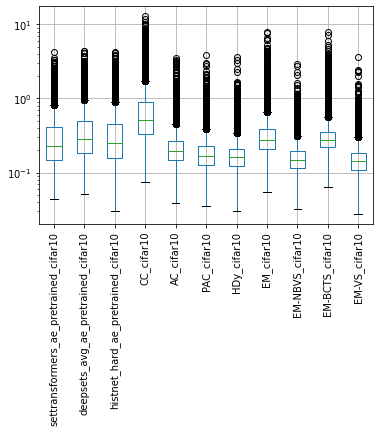

In [23]:
experiment_names = ["settransformers_ae_pretrained_cifar10","deepsets_avg_ae_pretrained_cifar10","histnet_hard_ae_pretrained_cifar10","CC_cifar10","AC_cifar10","PAC_cifar10","HDy_cifar10","EM_cifar10","EM-NBVS_cifar10","EM-BCTS_cifar10","EM-VS_cifar10"]
#,
cifar10_results=show_results_table(experiment_names,base_path="cifar_mnist",add_mse=True)
print(cifar10_results)
with open(os.path.join(export_dir,'tables/cifar10.tex'),'w') as f:
    f.write(cifar10_results)

## Resultados FASHIONMNIST

In [4]:
experiment_names = ["settransformers_ae_fashionmnist","settransformers_rae_fashionmnist","settransformers_mse_fashionmnist",
"deepsets_avg_ae_fashionmnist","deepsets_avg_ae_fashionmnist","deepsets_avg_rae_fashionmnist","deepsets_avg_mse_fashionmnist",
"deepsets_median_ae_fashionmnist","deepsets_median_rae_fashionmnist","deepsets_median_mse_fashionmnist","deepsets_max_ae_fashionmnist",
"deepsets_max_rae_fashionmnist","deepsets_max_mse_fashionmnist",
"histnet_hard_ae_fashionmnist","histnet_hard_rae_fashionmnist","histnet_hard_mse_fashionmnist",
#"histnet_hard_batched_ae_fashionmnist","histnet_hard_batched_rae_fashionmnist","histnet_hard_batched_mse_fashionmnist",
"CC_fashionmnist","PCC_fashionmnist","AC_fashionmnist","PAC_fashionmnist","HDy_fashionmnist",
"EM_fashionmnist","EM-NBVS_fashionmnist","EM-BCTS_fashionmnist","EM-VS_fashionmnist"]
#,

fashionmnist_results,_=show_results_table(experiment_names,base_path="cifar_mnist",include_std=True,error_measures=['AE','RAE','MSE'])
print(fashionmnist_results)
with open(os.path.join(export_dir,'tables/fashionmnist.tex'),'w') as f:
    f.write(fashionmnist_results)

\begin{tabular}{r|rrr}
\toprule
 & AE & RAE & MSE \\
\midrule
settransformers\_ae\_fashionmnist & 0.01043 $\pm$ 0.00328 & 0.37164 $\pm$ 0.44702 & 0.00021 $\pm$ 0.00017 \\
settransformers\_rae\_fashionmnist & 0.12947 $\pm$ 0.02279 & 2.20175 $\pm$ 1.19007 & 0.03305 $\pm$ 0.01029 \\
settransformers\_mse\_fashionmnist & 0.00882 $\pm$ 0.00270 & 0.34463 $\pm$ 0.40529 & 0.00014 $\pm$ 0.00011 \\
deepsets\_avg\_ae\_fashionmnist & 0.00829 $\pm$ 0.00254 & 0.29700 $\pm$ 0.34086 & 0.00013 $\pm$ 0.00010 \\
deepsets\_avg\_rae\_fashionmnist & 0.02494 $\pm$ 0.01429 & 0.32826 $\pm$ 0.23251 & 0.00226 $\pm$ 0.00345 \\
deepsets\_avg\_mse\_fashionmnist & 0.00834 $\pm$ 0.00252 & 0.32325 $\pm$ 0.37827 & 0.00013 $\pm$ 0.00009 \\
deepsets\_median\_ae\_fashionmnist & 0.00942 $\pm$ 0.00288 & 0.35496 $\pm$ 0.42178 & 0.00017 $\pm$ 0.00012 \\
deepsets\_median\_rae\_fashionmnist & 0.06554 $\pm$ 0.01760 & 0.71946 $\pm$ 0.58579 & 0.01203 $\pm$ 0.00792 \\
deepsets\_median\_mse\_fashionmnist & 0.00850 $\pm$ 0.00256 & 0.3

## Fashion-mnist resumida
### AE


In [7]:
experiment_names = ["settransformers_ae_fashionmnist","deepsets_avg_ae_fashionmnist","deepsets_median_ae_fashionmnist","deepsets_max_ae_fashionmnist","histnet_hard_ae_fashionmnist",
"CC_fashionmnist","PCC_fashionmnist","AC_fashionmnist","PAC_fashionmnist","HDy_fashionmnist",
"EM_fashionmnist","EM-NBVS_fashionmnist","EM-BCTS_fashionmnist","EM-VS_fashionmnist"]
row_names  = ["SetTransformers","Deepsets (avg)","Deepsets (median)","Deepsets (max)","HistNet",
"CC","PCC","ACC","PACC","HDy","EM","EM-NBVS","EM-BCTS","EM-VS"]
#,
fashionmnist_results,_=show_results_table(experiment_names,row_names = row_names, base_path="cifar_mnist",error_measures=['AE'])
print(fashionmnist_results)

experiment_names = ["settransformers_rae_fashionmnist","deepsets_avg_rae_fashionmnist","deepsets_median_rae_fashionmnist","deepsets_max_rae_fashionmnist","histnet_hard_rae_fashionmnist",
"CC_fashionmnist","PCC_fashionmnist","AC_fashionmnist","PAC_fashionmnist","HDy_fashionmnist",
"EM_fashionmnist","EM-NBVS_fashionmnist","EM-BCTS_fashionmnist","EM-VS_fashionmnist"]
fashionmnist_results,_=show_results_table(experiment_names, row_names = row_names, base_path="cifar_mnist",error_measures=['RAE'])
print(fashionmnist_results)

experiment_names = ["settransformers_mse_fashionmnist","deepsets_avg_mse_fashionmnist","deepsets_median_mse_fashionmnist","deepsets_max_mse_fashionmnist","histnet_hard_mse_fashionmnist",
"CC_fashionmnist","PCC_fashionmnist","AC_fashionmnist","PAC_fashionmnist","HDy_fashionmnist",
"EM_fashionmnist","EM-NBVS_fashionmnist","EM-BCTS_fashionmnist","EM-VS_fashionmnist"]
fashionmnist_results,_=show_results_table(experiment_names, row_names = row_names, base_path="cifar_mnist",error_measures=['MSE'])
print(fashionmnist_results)

\begin{tabular}{r|r}
\toprule
 & AE \\
\midrule
SetTransformers & 0.010435 \\
Deepsets (avg) & 0.008292 \\
Deepsets (median) & 0.009423 \\
Deepsets (max) & 0.021851 \\
HistNet & \textbf{0.006016} \\
CC & 0.016343 \\
PCC & 0.020403 \\
ACC & 0.008239 \\
PACC & 0.006729 \\
HDy & 0.007211 \\
EM & 0.013242 \\
EM-NBVS & 0.006649 \\
EM-BCTS & 0.013384 \\
EM-VS & 0.006478 \\
\bottomrule
\end{tabular}

\begin{tabular}{r|r}
\toprule
 & RAE \\
\midrule
SetTransformers & 2.201746 \\
Deepsets (avg) & 0.328262 \\
Deepsets (median) & 0.719457 \\
Deepsets (max) & 0.351952 \\
HistNet & \ddag{0.159235} \\
CC & 0.582785 \\
PCC & 0.781676 \\
ACC & 0.222564 \\
PACC & 0.183103 \\
HDy & 0.166974 \\
EM & 0.254928 \\
EM-NBVS & 0.154677 \\
EM-BCTS & 0.253795 \\
EM-VS & \textbf{0.153072} \\
\bottomrule
\end{tabular}

\begin{tabular}{r|r}
\toprule
 & MSE \\
\midrule
SetTransformers & 0.000142 \\
Deepsets (avg) & 0.000129 \\
Deepsets (median) & 0.000131 \\
Deepsets (max) & 0.001037 \\
HistNet & \textbf{0.000077} \

## Optimizando diferentes medidas de error

\begin{tabular}{r|rr}
\toprule
{} & {AE} & {RAE} & {MSE} \\
\midrule
histnet\_hard\_ae\_pretrained\_cifar10 & \ddag{0.010319} & 0.404029 & 0.000210 \\
histnet\_hard\_rae\_pretrained\_cifar10 & 0.011900 & \textbf{0.293156} & 0.000293 \\
histnet\_hard\_mse\_pretrained\_cifar10 & \textbf{0.010241} & 0.448482 & \textbf{0.000182} \\
\bottomrule
\end{tabular}



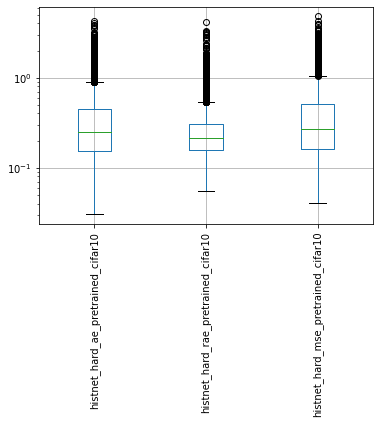

In [21]:
experiment_names = ["histnet_hard_ae_pretrained_cifar10","histnet_hard_rae_pretrained_cifar10","histnet_hard_mse_pretrained_cifar10"]
#,
cifar10_results=show_results_table(experiment_names,base_path="cifar_mnist",add_mse=True)
print(cifar10_results)
with open(os.path.join(export_dir,'tables/cifar10.tex'),'w') as f:
    f.write(cifar10_results)

## Comparación con baselines la competición LEQUA

In [ ]:
from dlquantification.utils.lossfunc import MRAE
import torch

def compute_errors(baselines,baseline_path,test_prevalences,dataset,loss_mrae):
    test_prevalences = pd.read_csv(test_prevalences)
    for baseline in baselines:
        export_path = os.path.join("results/", baseline + "_"+dataset+"_errors.txt")
        if not os.path.exists(export_path):
            errors = pd.DataFrame(columns=('AE','RAE'),index=range(5000))
            results = pd.read_csv(os.path.join(baseline_path,baseline)+'.csv')
            for i in range(len(results)):
                errors.iloc[i]['RAE']=loss_mrae(torch.FloatTensor(test_prevalences.iloc[i,1:].to_numpy()), torch.FloatTensor(results.iloc[i,1:].to_numpy())).numpy()
                errors.iloc[i]['AE']=torch.nn.functional.l1_loss(torch.FloatTensor(test_prevalences.iloc[i,1:].to_numpy()), torch.FloatTensor(results.iloc[i,1:].to_numpy())).numpy()
            errors.to_csv(export_path, index_label="id")


baselines=['CC','ACC','HDy','PACC','PCC','QuaNet','SLD']
#For this experiments we need to compute the errors as we only have the predictions

loss_mrae = MRAE(eps=1.0 / (2 * 250), n_classes=2).MRAE
baseline_path_T1A = os.path.join(path,'codalab/T1A')
test_prevalences = './lequa/T1A/public/test_prevalences.txt'
compute_errors(baselines,baseline_path_T1A,test_prevalences,'T1A',loss_mrae)
baselines=['CC','ACC','PACC','PCC','SLD']
loss_mrae = MRAE(eps=1.0 / (2 * 1000), n_classes=28).MRAE
baseline_path_T1B = os.path.join(path,'codalab/T1B')
test_prevalences = './lequa/T1B/public/test_prevalences.txt'
compute_errors(baselines,baseline_path_T1B,test_prevalences,'T1B',loss_mrae)

\begin{tabular}{r|rr}
\toprule
{} & {AE} & {RAE} \\
\midrule
CC\_T1A & 0.091604 & 1.083997 \\
PCC\_T1A & 0.116639 & 1.394021 \\
ACC\_T1A & 0.037157 & 0.170201 \\
PACC\_T1A & 0.029849 & 0.152185 \\
HDy\_T1A & 0.028143 & 0.145141 \\
QuaNet\_T1A & 0.034183 & 0.317637 \\
SLD\_T1A & 0.025184 & 0.113823 \\
histnet\_hard\_T1A & \textbf{0.022365} & \textbf{0.107073} \\
\bottomrule
\end{tabular}



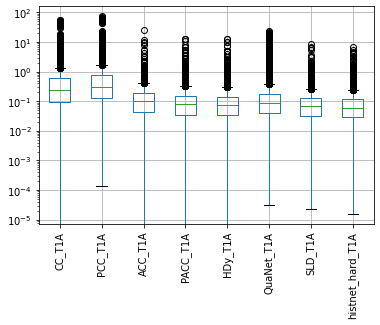

In [ ]:
experiment_names = ["CC_T1A","PCC_T1A","ACC_T1A","PACC_T1A","HDy_T1A","QuaNet_T1A","SLD_T1A","histnet_hard_T1A"]
baseline_results=show_results_table(experiment_names)
print(baseline_results)
with open(os.path.join(export_dir,'tables/baselines_t1a.tex'),'w') as f:
    f.write(baseline_results)

\begin{tabular}{r|rr}
\toprule
{} & {AE} & {RAE} \\
\midrule
CC\_T1B & 0.014056 & 1.893649 \\
PCC\_T1B & 0.017114 & 2.264615 \\
ACC\_T1B & 0.018412 & 1.421342 \\
PACC\_T1B & 0.015777 & 1.305378 \\
SLD\_T1B & 0.019763 & 1.182070 \\
histnet\_hard\_T1B & \textbf{0.012119} & \textbf{0.785138} \\
\bottomrule
\end{tabular}



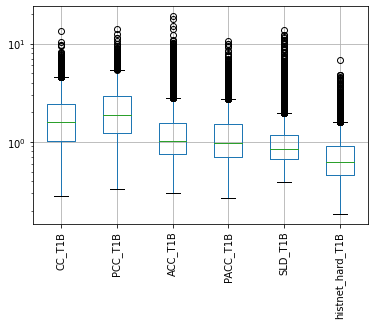

In [ ]:
experiment_names = ["CC_T1B","PCC_T1B","ACC_T1B","PACC_T1B","SLD_T1B","histnet_hard_T1B"]
baseline_results=show_results_table(experiment_names)
print(baseline_results)
with open(os.path.join(export_dir,'tables/baselines_t1b.tex'),'w') as f:
    f.write(baseline_results)